# Part 2: Modeling & Evaluation

## Imports

In [47]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
from keras                   import regularizers
from keras.models            import Sequential
from keras.layers            import Dense, Dropout
from keras.optimizers        import Adam
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics         import roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics         import f1_score, fbeta_score
from sklearn.pipeline        import Pipeline
from IPython.core.display    import display, HTML
from IPython.display         import display_html
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

## Table Of Contents

- [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    
    
- [Feature Engineering](#Feature-Engineering)
    - [Data Manipulation](#Data-Manipulation)
    - [Interaction Columns](#Interaction-Columns)
    
    
- [Establishing The Baseline](#Establishing-The-Baseline)
    
    
- [Modeling](#Modeling)
    - [Subset Definition](#Subset-Definition)
    - [Defining X & y Variables](#Defining-X-&-y-Variables)
    - [Train-Test Split](#Train-Test-Split)
    - [Evaluation Functions](#Evaluation-Functions)
    - [Neural Networks](#Neural-Networks)
        - [Original Features](#Original-Features)
        - [Squared Features](#Squared-Features)
        - [Interaction Features](#Interaction-Features)

## Reading In The Data

In [3]:
pulsar = pd.read_csv("../Data/pulsar_cleaned.csv")

### Overview

In [4]:
# Checking the head of the data

pulsar.head()

,mean_ip,sd_ip,ex_kurt_ip,skew_ip,mean_dmsnr,sd_dmsnr,ex_kurt_dmsnr,skew_dmsnr,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [5]:
# Checking the shape of the data

print(f"The shape of the dataset is: {pulsar.shape}")

The shape of the dataset is: (17898, 9)


In [6]:
# Summary of column data types

pulsar.dtypes.value_counts()

float64    8
int64      1
dtype: int64

In [7]:
# Checking for null values

pulsar.isnull().sum()

mean_ip          0
sd_ip            0
ex_kurt_ip       0
skew_ip          0
mean_dmsnr       0
sd_dmsnr         0
ex_kurt_dmsnr    0
skew_dmsnr       0
target_class     0
dtype: int64

[Top](#Table-Of-Contents)

## Feature Engineering

### Data Manipulation

While visualizing the data, we noticed that there are two columns that appeared to have a close to normal distribution.  As a result, we decided to square the values to transform them.

In [8]:
# Squaring the `mean_ip` column

pulsar["mean_ip_squared"] = pulsar["mean_ip"].apply(lambda x: x**2)

# Squaring the `sd_ip` column

pulsar["sd_ip_squared"]   = pulsar["sd_ip"].apply(lambda x: x**2)

In [9]:
# Making sure new columns were added

pulsar.columns

Index(['mean_ip', 'sd_ip', 'ex_kurt_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr',
       'ex_kurt_dmsnr', 'skew_dmsnr', 'target_class', 'mean_ip_squared',
       'sd_ip_squared'],
      dtype='object')

### Interaction Columns

Based off of the heat map in the previous notebook, we noticed that there are some columns with very high correlations.  We felt that creating interaction columns, we would be emphasizing the correlation while also reducing the number of features.


The columns in particular are:


| Column 1   | Column 2   | Correlation |
|:-----------|:-----------|:-----------:|
| mean_ip    | sd_ip      | 0.55        |
| ex_kurt_ip | skew_ip    | 0.95        |
| mean_dmsnr | sd_dmsnr   | 0.80        |
| ex_kurt_ip | skew_dmsnr | 0.92        |


We chose these columns in particular because they allows us to reduce the number of features that will end up going into the model.  However, we decided not to get ride of the eight original features: we will end up with sub-sets of the model we will model on.

In [10]:
# Defining the `mean_ip` * `sd_ip` colum
# Defining the `ex_kurt_ip` * `skew_ip` colum

pulsar["mean_*_sd_ip"]     = pulsar["mean_ip"] * pulsar["sd_ip"]
pulsar["exkurt_*_skew_ip"] = pulsar["ex_kurt_ip"] * pulsar["skew_ip"]

# Defining the `mean_dmsnr` * `sd_dmsnr` colum
# Defining the `ex_kurt_dmsnr` * `skew_dmsnr` colum

pulsar["mean_*_sd_dmsnr"]     = pulsar["mean_dmsnr"] * pulsar["sd_dmsnr"]
pulsar["exkurt_*_skew_dmsnr"] = pulsar["ex_kurt_dmsnr"] * pulsar["skew_dmsnr"]

In [11]:
# Checking to make sure columns were created

pulsar.columns

Index(['mean_ip', 'sd_ip', 'ex_kurt_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr',
       'ex_kurt_dmsnr', 'skew_dmsnr', 'target_class', 'mean_ip_squared',
       'sd_ip_squared', 'mean_*_sd_ip', 'exkurt_*_skew_ip', 'mean_*_sd_dmsnr',
       'exkurt_*_skew_dmsnr'],
      dtype='object')

## Establishing The Baseline

We need to know what our baseline accuracy is because that will give us an accuracy score to beat: if our accuracy is less than the baseline it means that our model is worse than guessing the category of a star.

In [12]:
# Calculating the percentages of each class

round(pulsar["target_class"].value_counts(normalize = True)*100, 2)

0    90.84
1     9.16
Name: target_class, dtype: float64

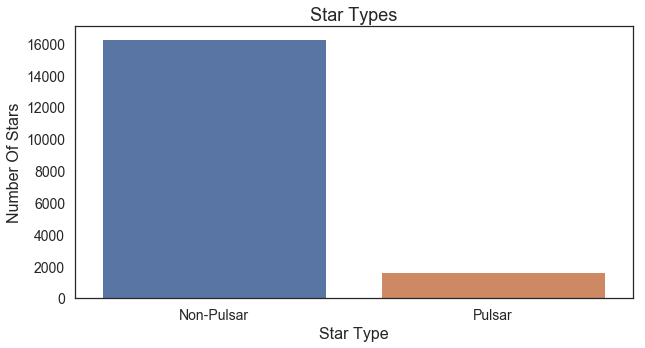

In [14]:
# Plotting the distribution of the classes

tick_labels = ["Non-Pulsar", "Pulsar"]

# Setting the figure size
plt.figure(figsize = (10,5))

# Plotting the graph
sns.countplot(pulsar["target_class"])

# Setting graph parameters
plt.title("Star Types", size = 18)
plt.xlabel("Star Type", size = 16)
plt.ylabel("Number Of Stars", size = 16)

# Making sure the only ticks are 0 and 1
plt.xticks(np.arange(0,2,1),
           labels = tick_labels,
           size   = 14)
plt.yticks(size = 14);

The data is _extremely_ imbalanced: this will make it difficult to model because the negative class (non-pulsar) is so much less frequent than the positive class (pulsar).

[Top](#Table-Of-Contents)

## Modeling

We decided that because of the extreme imbalance of the classes a feed forward neural network is the best approach to predicting the presence of a pulsar.

### Subset Definition

Because of the way we set up the interaction columns and manipulated the data, we decided that we are best off with three subsets: the original features, original features with squared columns, and the interaction columns.  We have to define the subsets before we define our X and y variables.

In [15]:
# List of the original features

original_features = ["mean_ip", "sd_ip", "ex_kurt_ip", "skew_ip",
                     "mean_dmsnr", "sd_dmsnr", "ex_kurt_dmsnr", "skew_dmsnr",
                     "target_class"]

# List of the original features with `mean_ip` and `sd_ip` squared

manipulated_features = ["mean_ip_squared", "sd_ip_squared", "ex_kurt_ip", "skew_ip",
                        "mean_dmsnr", "sd_dmsnr", "ex_kurt_dmsnr", "skew_dmsnr",
                        "target_class"]

# List of the interaction features

interaction_features = ["mean_*_sd_ip", "exkurt_*_skew_ip", "mean_*_sd_dmsnr",
                        "exkurt_*_skew_dmsnr", "target_class"]

In [16]:
# Defining a subset with the original features

pulsar_og = pulsar[original_features]

# Defining a subset with the original/squared features

pulsar_sq = pulsar[manipulated_features]

# Defining a subset with the interaction features

pulsar_if = pulsar[interaction_features]

### Defining X & y Variables

From this point on `X` and `y` will refer to the original features, `_sq` will refer to the dataframe with the squared features, and `_if` will refer to the dataframe with interaction features.

In [17]:
# X and y for the original

X = pulsar_og.drop("target_class", axis = 1)
y = pulsar_og["target_class"]

# X and y for the original/squared features

X_sq = pulsar_sq.drop("target_class", axis = 1)
y_sq = pulsar_sq["target_class"]

# X and y for the interaction features

X_if = pulsar_if.drop("target_class", axis = 1)
y_if = pulsar_if["target_class"]

### Train-Test Split

The purpose of the train-test split is to split up our data so that we can reserve an unseen portion of it to test our model on.  Additionally, we will be setting a random state for reproducability and we will stratify on `y` so that the distribution of classes is preserved.

In [18]:
# For the original data

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

# For the original data with squared features

X_sq_train, X_sq_test, y_sq_train, y_sq_test = train_test_split(X_sq,
                                                                y_sq,
                                                                random_state = 42,
                                                                stratify     = y_sq )

# For the dataframe with interaction features

X_if_train, X_if_test, y_if_train, y_if_test = train_test_split(X_if,
                                                                y_if,
                                                                random_state = 42,
                                                                stratify     = y_if)

[Top](#Table-Of-Contents)

### Evaluation Functions

A confusion matrix gives us a summary of how our model classified the test data: it compares the true and predicted y values so that we can see how the model performed on each class.


Each confusion matrix is set up the same way:

|                     | Predicted Positive | Predicted Negative |
|:--------------------|:------------------:|:------------------:|
| **Actual Positive** | True Positive      | False Negative     |
| **Actual Negative** | False Positive     | True Negative      |

In [19]:
# We converted the confusion matrix to a dataframe to make it easier to read

def create_confusion_matrix(y, y_preds):
    cm     = confusion_matrix(y, y_preds)
    matrix = pd.DataFrame(cm, 
                          columns = ["Predicted Pulsar", "Predicted Non-Pulsar"], 
                          index   = ["Actual Pulsar", "Actual Non-Pulsar"])
    return matrix

We will generate two scores based off of the confusion matrix: specificity and sensitivity; we will go into what these scores measure in a few cells.

In [20]:
# Calculating specificity from a confusion matrix

def specificity(y, y_pred):
    cm          = confusion_matrix(y, y_pred)  
    specificity = cm[1,1] / (cm[1,1] + cm[1,0])
    return specificity

# Calculating sensitivity from a confusion matrix

def sensitivity(y, y_pred):
    cm          = confusion_matrix(y, y_pred)
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
    return sensitivity

In addition to metric scores, we will also calculate an ROC-AUC score.  The ROC (receiver operating characteristic) shows us a binary classification model's ability to distinguish between two classes; we will plot this curve for the best model as determined by metric scores.

These images from [GreyAtom](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) illustrates the AUC-ROC well:

<img src = "../Images/ROC_AUC 0.8 0.9.png" alt = "high auc_roc scores" height = "350" width = "350">

<img src = "../Images/ROC_AUC 0.5 0.7.png" alt = "low auc_roc scores"  height = "350" width = "350">


Accuracy is not the most informative score for us: it just counts how many posts were classified correctly.  Instead, we want to look at performance regarding the predicted positives (pulsars) and negatives (non-pulsars).  We will use the following scores:

| Metric                | Definition                                                       | Scale    |
|:----------------------|:-----------------------------------------------------------------|:---------|
| **Balanced Accuracy** | The average of the recall on each class                          | 0 to 1   | 
| **Specificity**       | How many negative predictions are correct                        | 0 to 1   | 
| **Sensitivity**       | How many positive predictions are correct (also known as recall) | 0 to 1   | 
| **F1 Score**          | Accuracy that takes into account the specificity & sensitivity   | 0 to 1   | 
| **F2 Score**          | Same as the F1 score, but weights the sensitivity twice as much  | 0 to 1   |  
| **ROC-AUC Score**     | A measure of the model's ability to distinguish classes          | 0.5 to 1 |

One of the parameters for the F1, F2, and ROC-AUC scores is called `average` which, as the name suggests, controls how the averages are calculate.  The default is `binary`, but because our classes are extremely unbalanced we will use the value `macro` which calculates the score on each class but does _not_ apply any kind of weighting; doing this ignores the class imbalance.

In [21]:
# Generating the 6 metric evaluation

def generate_model_eval(y, y_pred):
    print(f"The balanced accuracy score is: {round(balanced_accuracy_score(y, y_pred), 5)}")
    print(f"The specificity score is      : {round(specificity(y, y_pred), 5)}")
    print(f"The sensitivity score is      : {round(sensitivity(y, y_pred), 5)}")
    print(f"The F1 score is               : {round(f1_score(y, y_pred, average = 'macro'), 5)}")
    print(f"The F2 score is               : {round(fbeta_score(y, y_pred, beta = 2.0, average = 'macro'))}")
    print(f"The ROC-AUC score is          : {round(roc_auc_score(y, y_pred, average = 'macro'), 5)}")

[Top](#Table-Of-Contents)

### Neural Networks

<img src = "../Images/neural_network.jpg" alt = "simple neural network" height = "350" width = "400">


A neural network is a modeling technique that consists of a number of simple but highly interconnected elements or nodes or neurons 
which are organized in layers.


- **Input layer**: the number of features in the data; in our case, the number of columns


- **Hidden layer(s)**: the "middle" features and are called hidden because they are neither the input nor output.  The hidden layer(s) are where the actual computations take place: using weights and biases they modify linear models.  The hidden layers also have activation functions which modify the output in some way; the most common activation function is ReLU (rectified linear unit) which forces the hidden layer to be positive.


- **Output layer**: what the actual result of the computation is and they determine what the results look like.  In the case of regression, it is a number whereas in classification the output is a probability.


If we are not careful, our neural networks can become _extremely_ complicated and overfit to the training data.  To combat that, we will regularize the models.


The models will have the following structure:

- A dense network

- An input layer

- Hidden layers
    - ReLU activation

- Single output layer
    - Sigmoid activation

#### Original Features

In [27]:
# Defining the input size

input_shape = X_train.shape[1]

# Instantiating the model

of_model = Sequential()

# Adding a primary dense layer

of_model.add(Dense(6,
                   input_dim          = input_shape,
                   activation         = "relu",
                   kernel_regularizer = regularizers.l2(0.01)))

# Adding an output layer

of_model.add(Dense(1,
                   activation         = "sigmoid",
                   kernel_regularizer = regularizers.l2(0.01)))

# Compiling the model

of_model.compile(loss      = "binary_crossentropy",
                 optimizer = "adam",
                 metrics   = ["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
# Fitting the model

of_model.fit(X_train,
             y_train,
             epochs     = 150,
             batch_size = 100,
             verbose    = 0)

In [44]:
# Generating training predictions

of_train_preds = of_model.predict_classes(X_train,
                                          batch_size = 100,
                                          verbose    = 0).ravel()

# Generating test predictions

of_test_preds = of_model.predict_classes(X_test,
                                         batch_size = 100,
                                         verbose    = 0).ravel()

In [49]:
generate_model_eval(y_train, of_train_preds)

The balanced accuracy score is: 0.88252
The specificity score is      : 0.77136
The sensitivity score is      : 0.99369
The F1 score is               : 0.91331
The F2 score is               : 1.0
The ROC-AUC score is          : 0.88252


In [48]:
generate_model_eval(y_test, of_test_preds)

The balanced accuracy score is: 0.89108
The specificity score is      : 0.78537
The sensitivity score is      : 0.9968
The F1 score is               : 0.92606
The F2 score is               : 1.0
The ROC-AUC score is          : 0.89108
